# Distance-based treatment effects (plot for different stroke types)

Based on the figures from Holodinsky et al. 2017 - "Drip and Ship Versus Direct to Comprehensive Stroke Center"

Here we show the difference in outcome measures for nLVO, LVO, and a mixed population (65% nLVO, 35% LVO). There is 60 min travel time between IVT and MT centres.

## Notebook admin

In [1]:
# Import packages
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import copy

from stroke_outcome.continuous_outcome import Continuous_outcome

from outcome_utilities.geography_plot import find_mask_within_flattened_circle

In [2]:
# Keep notebook cleaner once finalised
import warnings
warnings.filterwarnings('ignore')

In [3]:
import stroke_outcome

In [4]:
stroke_outcome.__version__

'0.1.6'

## Assumptions 

Fixed times for additional delays:

In [5]:
# All fixed times have units of minutes
fixed_times = dict(
    onset_to_ambulance_arrival = 60,
    ivt_arrival_to_treatment = 30,
    transfer_additional_delay = 60,
    travel_ivt_to_mt = 60,
    mt_arrival_to_treatment = 90,
)

### Travel time grids

Define a helper function to build the time grid:

In [6]:
def make_time_grid(xy_max, step, x_offset=0, y_offset=0):
    # Times for each row....
    x_times = np.arange(-xy_max, xy_max + step, step) - x_offset
    # ... and each column.
    y_times = np.arange(-xy_max, xy_max + step, step) - y_offset
    # The offsets shift the position of (0,0) from the grid centre 
    # to (x_offset, y_offset). Distances will be calculated from the
    # latter point. 

    # Mesh to create new grids by stacking rows (xx) and columns (yy):
    xx, yy = np.meshgrid(x_times, y_times)

    # Then combine the two temporary grids to find distances: 
    radial_times = np.sqrt(xx**2.0 + yy**2.0)
    return radial_times

In [7]:
ivt_coords = [0, 0]
mt_coords  = [0, -fixed_times['travel_ivt_to_mt']]

In [8]:
# Only calculate travel times up to this x or y displacement:
time_travel_max = 60

# Change how granular the grid is. 
grid_step = 1  # minutes

# Make the grid a bit larger than the max travel time: 
grid_xy_max = time_travel_max + grid_step*2

Build the grids:

In [9]:
grid_time_travel_directly_to_ivt = make_time_grid(
    time_travel_max,
    grid_step,
    x_offset=ivt_coords[0], 
    y_offset=ivt_coords[1]
)

In [10]:
grid_time_travel_directly_to_mt = make_time_grid(
    time_travel_max,
    grid_step,
    x_offset=mt_coords[0],
    y_offset=mt_coords[1]
)

In [11]:
grid_time_travel_directly_diff = (
    grid_time_travel_directly_to_ivt - grid_time_travel_directly_to_mt)

In [12]:
extent = [
    -grid_xy_max - grid_step*0.5,
    +grid_xy_max - grid_step*0.5,
    -grid_xy_max - grid_step*0.5,
    +grid_xy_max - grid_step*0.5
]

In [13]:
grid_mask = find_mask_within_flattened_circle(
    grid_time_travel_directly_diff, 
    grid_time_travel_directly_to_ivt, 
    time_travel_max
)

coords_valid = np.where(grid_mask<1)

### Treatment time grids

In [14]:
grid_time_ivt_at_ivtcentre = (
    fixed_times['onset_to_ambulance_arrival'] + 
    grid_time_travel_directly_to_ivt + 
    fixed_times['ivt_arrival_to_treatment']
    )

In [15]:
grid_time_ivt_at_ivt_then_mt_at_mtcentre = (
    fixed_times['onset_to_ambulance_arrival'] + 
    grid_time_travel_directly_to_ivt + 
    fixed_times['ivt_arrival_to_treatment'] + 
    fixed_times['transfer_additional_delay'] + 
    fixed_times['travel_ivt_to_mt'] + 
    fixed_times['mt_arrival_to_treatment']
    )

In [16]:
grid_time_ivt_at_mtcentre = (
    fixed_times['onset_to_ambulance_arrival'] + 
    grid_time_travel_directly_to_mt + 
    fixed_times['ivt_arrival_to_treatment']
    )

In [17]:
grid_time_ivt_then_mt_at_mtcentre = (
    fixed_times['onset_to_ambulance_arrival'] + 
    grid_time_travel_directly_to_mt + 
    fixed_times['mt_arrival_to_treatment']
    )

__check the assumption of time between IVT and MT at the same centre above__

### Create outcome model inputs

In [18]:
df_ivtcentre = pd.DataFrame()
df_ivtcentre['onset_to_needle_mins'] = grid_time_ivt_at_ivtcentre.flatten()
df_ivtcentre['onset_to_puncture_mins'] = grid_time_ivt_at_ivt_then_mt_at_mtcentre.flatten()

In [19]:
df_ivtmtcentre = pd.DataFrame()
df_ivtmtcentre['onset_to_needle_mins'] = grid_time_ivt_at_mtcentre.flatten()
df_ivtmtcentre['onset_to_puncture_mins'] = grid_time_ivt_then_mt_at_mtcentre.flatten()

Assign three cohorts to these treatment times:

+ nLVO + IVT
+ LVO + IVT
+ LVO + MT

In [20]:
df_ivtcentre_nlvo_ivt = df_ivtcentre.copy()
df_ivtcentre_nlvo_ivt['stroke_type_code'] = 1
df_ivtcentre_nlvo_ivt['ivt_chosen_bool'] = 1
df_ivtcentre_nlvo_ivt['mt_chosen_bool'] = 0

In [21]:
df_ivtmtcentre_nlvo_ivt = df_ivtmtcentre.copy()
df_ivtmtcentre_nlvo_ivt['stroke_type_code'] = 1
df_ivtmtcentre_nlvo_ivt['ivt_chosen_bool'] = 1
df_ivtmtcentre_nlvo_ivt['mt_chosen_bool'] = 0

In [22]:
df_ivtcentre_lvo_ivt = df_ivtcentre.copy()
df_ivtcentre_lvo_ivt['stroke_type_code'] = 2
df_ivtcentre_lvo_ivt['ivt_chosen_bool'] = 1
df_ivtcentre_lvo_ivt['mt_chosen_bool'] = 0

In [23]:
df_ivtmtcentre_lvo_ivt = df_ivtmtcentre.copy()
df_ivtmtcentre_lvo_ivt['stroke_type_code'] = 2
df_ivtmtcentre_lvo_ivt['ivt_chosen_bool'] = 1
df_ivtmtcentre_lvo_ivt['mt_chosen_bool'] = 0

In [24]:
df_ivtcentre_lvo_mt = df_ivtcentre.copy()
df_ivtcentre_lvo_mt['stroke_type_code'] = 2
df_ivtcentre_lvo_mt['ivt_chosen_bool'] = 1
df_ivtcentre_lvo_mt['mt_chosen_bool'] = 1

In [25]:
df_ivtmtcentre_lvo_mt = df_ivtmtcentre.copy()
df_ivtmtcentre_lvo_mt['stroke_type_code'] = 2
df_ivtmtcentre_lvo_mt['ivt_chosen_bool'] = 1
df_ivtmtcentre_lvo_mt['mt_chosen_bool'] = 1

### Calculate outcomes

In [26]:
# Set up outcome model
outcome_model = Continuous_outcome()

In [27]:
dfs = [
    df_ivtcentre_nlvo_ivt,
    df_ivtmtcentre_nlvo_ivt,
    df_ivtcentre_lvo_ivt,
    df_ivtmtcentre_lvo_ivt,
    df_ivtcentre_lvo_mt,
    df_ivtmtcentre_lvo_mt,
]

for df in dfs:
    outcome_model.assign_patients_to_trial(df)
    
    # Calculate outcomes:
    patient_data_dict, outcomes_by_stroke_type, full_cohort_outcomes = (
        outcome_model.calculate_outcomes())
    
    # Make a copy of the results:
    outcomes_by_stroke_type = copy.copy(outcomes_by_stroke_type)
    full_cohort_outcomes = copy.copy(full_cohort_outcomes)
    
    # Place the relevant results into the starting dataframe:
    df['added_utility'] = full_cohort_outcomes['each_patient_utility_shift']
    df['mean_mrs'] = full_cohort_outcomes['each_patient_mrs_post_stroke']
    df['mrs_less_equal_2'] = full_cohort_outcomes['each_patient_mrs_dist_post_stroke'][:, 2]
    df['mrs_shift'] = full_cohort_outcomes['each_patient_mrs_shift']

### Mixed cohort

Calculate outcomes for the combined cohorts.

Patient population:

In [28]:
patient_props = dict(
    lvo = 0.35,
    nlvo = 1.0-0.35, # 1-LVO
    lvo_mt_also_receiving_ivt = 0.85,
    lvo_treated_ivt_only = 0.0,
    lvo_treated_ivt_mt = 0.286,    # 0.286 gives 10% final MT if 35%LVO
    nlvo_treated_ivt_only = 0.155,    # 0.155 gives final 20% IVT
    )

treated_population = (
    patient_props['nlvo'] * patient_props['nlvo_treated_ivt_only'] +
    patient_props['lvo'] * patient_props['lvo_treated_ivt_mt'] +
    patient_props['lvo'] * patient_props['lvo_treated_ivt_only']
    )

patient_props['treated_population'] = treated_population

Display these values:

In [29]:
df_patients = pd.DataFrame(patient_props.values(), 
    index=patient_props.keys(), columns=['Proportion of patient population'])
df_patients['Comment'] = [
    'Proportion of LVO',
    'Proportion of nLVO', 
    'Proportion LVO MT also receiving IVT',
    'Proportion LVO admissions treated with IVT only',
    'Proportion LVO admissions treated with MT',
    'Proportion nLVO admissions treated with IVT',
    'Proportion all admissions treated'
    ]

df_patients

,Proportion of patient population,Comment
lvo,0.35000,Proportion of LVO
nlvo,0.65000,Proportion of nLVO
lvo_mt_also_receiving_ivt,0.85000,Proportion LVO MT also receiving IVT
lvo_treated_ivt_only,0.00000,Proportion LVO admissions treated with IVT only
lvo_treated_ivt_mt,0.28600,Proportion LVO admissions treated with MT
nlvo_treated_ivt_only,0.15500,Proportion nLVO admissions treated with IVT
treated_population,0.20085,Proportion all admissions treated


In [30]:
outcome_cols = ['added_utility', 'mean_mrs', 'mrs_less_equal_2', 'mrs_shift']

IVT centre grid:

In [31]:
# Combine the outcomes:
df_mixed_ivtcentre = pd.DataFrame(
    np.sum((
        patient_props['nlvo'] * patient_props['nlvo_treated_ivt_only'] * df_ivtcentre_nlvo_ivt[outcome_cols],
        patient_props['lvo'] * patient_props['lvo_treated_ivt_only'] * df_ivtcentre_lvo_ivt[outcome_cols],
        patient_props['lvo'] * patient_props['lvo_treated_ivt_mt'] * df_ivtcentre_lvo_mt[outcome_cols],
    ), axis=0),
    columns=outcome_cols
)

# Adjust outcomes for just the treated population:
df_mixed_ivtcentre = df_mixed_ivtcentre / patient_props['treated_population']

# Copy over the treatment times.
# They're the same times in all three dataframes so just pick the nLVO IVT df:
df_mixed_ivtcentre['onset_to_needle_mins'] = df_ivtcentre_nlvo_ivt['onset_to_needle_mins']
df_mixed_ivtcentre['onset_to_puncture_mins'] = df_ivtcentre_nlvo_ivt['onset_to_puncture_mins']

MT centre grid:

In [32]:
# Combine the outcomes:
df_mixed_ivtmtcentre = pd.DataFrame(
    np.sum((
        patient_props['nlvo'] * patient_props['nlvo_treated_ivt_only'] * df_ivtmtcentre_nlvo_ivt[outcome_cols],
        patient_props['lvo'] * patient_props['lvo_treated_ivt_only'] * df_ivtmtcentre_lvo_ivt[outcome_cols],
        patient_props['lvo'] * patient_props['lvo_treated_ivt_mt'] * df_ivtmtcentre_lvo_mt[outcome_cols],
    ), axis=0),
    columns=outcome_cols
)

# Adjust outcomes for just the treated population:
df_mixed_ivtmtcentre = df_mixed_ivtmtcentre / patient_props['treated_population']

# Copy over the treatment times.
# They're the same times in all three dataframes so just pick the nLVO IVT df:
df_mixed_ivtmtcentre['onset_to_needle_mins'] = df_ivtmtcentre_nlvo_ivt['onset_to_needle_mins']
df_mixed_ivtmtcentre['onset_to_puncture_mins'] = df_ivtmtcentre_nlvo_ivt['onset_to_puncture_mins']

### Combine LVO only

IVT centre grid:

In [33]:
# Combine the outcomes:
df_lvo_ivtcentre = pd.DataFrame(
    np.sum((
        patient_props['lvo'] * patient_props['lvo_treated_ivt_only'] * df_ivtcentre_lvo_ivt[outcome_cols],
        patient_props['lvo'] * patient_props['lvo_treated_ivt_mt'] * df_ivtcentre_lvo_mt[outcome_cols],
    ), axis=0),
    columns=outcome_cols
)

# Adjust outcomes for just the treated population:
df_lvo_ivtcentre = df_lvo_ivtcentre / (patient_props['lvo_treated_ivt_only'] + patient_props['lvo_treated_ivt_mt'])

# Copy over the treatment times.
# They're the same times in all three dataframes so just pick the LVO IVT df:
df_lvo_ivtcentre['onset_to_needle_mins'] = df_ivtcentre_lvo_ivt['onset_to_needle_mins']
df_lvo_ivtcentre['onset_to_puncture_mins'] = df_ivtcentre_lvo_ivt['onset_to_puncture_mins']

MT centre grid:

In [34]:
# Combine the outcomes:
df_lvo_ivtmtcentre = pd.DataFrame(
    np.sum((
        patient_props['lvo'] * patient_props['lvo_treated_ivt_only'] * df_ivtmtcentre_lvo_ivt[outcome_cols],
        patient_props['lvo'] * patient_props['lvo_treated_ivt_mt'] * df_ivtmtcentre_lvo_mt[outcome_cols],
    ), axis=0),
    columns=outcome_cols
)

# Adjust outcomes for just the treated population:
df_lvo_ivtmtcentre = df_lvo_ivtmtcentre / (patient_props['lvo_treated_ivt_only'] + patient_props['lvo_treated_ivt_mt'])

# Copy over the treatment times.
# They're the same times in all three dataframes so just pick the LVO IVT df:
df_lvo_ivtmtcentre['onset_to_needle_mins'] = df_ivtmtcentre_lvo_ivt['onset_to_needle_mins']
df_lvo_ivtmtcentre['onset_to_puncture_mins'] = df_ivtmtcentre_lvo_ivt['onset_to_puncture_mins']

### Difference grids

Calculate the differences:

In [35]:
df_nlvo_ivt_diff = df_ivtmtcentre_nlvo_ivt - df_ivtcentre_nlvo_ivt
df_lvo_diff = df_lvo_ivtmtcentre - df_lvo_ivtcentre
df_lvo_ivt_diff = df_ivtmtcentre_lvo_ivt - df_ivtcentre_lvo_ivt
df_lvo_mt_diff = df_ivtmtcentre_lvo_mt - df_ivtcentre_lvo_mt
df_mixed_diff = df_mixed_ivtmtcentre - df_mixed_ivtcentre

# Combined circle plot

In [36]:
from outcome_utilities.geography_plot import circle_plot

Share these colour limits between all figures:

In [221]:
vmin_time = 0 
vmax_time = 60
vmin_util = -0.0375 # -0.045
vmax_util = 0.0500 # 0.035
vmin_mRS = -0.25 # -0.250 
vmax_mRS = 0.15 # 0.175
vmin_good = -0.0300
vmax_good = 0.0500

Make new colour maps that are based on a diverging colour map but have the zero (white) off-centre:

In [222]:
from outcome_utilities.geography_plot import make_new_cmap_diverging

cmap_util = make_new_cmap_diverging(
    vmin_util, vmax_util, cmap_base='bwr_r', cmap_name='bwr_util')
cmap_mRS = make_new_cmap_diverging(
    vmin_mRS, vmax_mRS, cmap_base='bwr', cmap_name='bwr_mRS')
cmap_good = make_new_cmap_diverging(
    vmin_good, vmax_good, cmap_base='bwr_r', cmap_name='bwr_good')

# For the time colours, take only the red half of 'bwr':
from matplotlib import colors
colours_time = plt.get_cmap('bwr')(np.linspace(0.5, 1.0, 256))
cmap_time = colors.LinearSegmentedColormap.from_list('bwr_time', colours_time)

Define contour levels for plotting: 

In [223]:
from outcome_utilities.geography_plot import make_levels_with_zeroish

level_step_util = 0.0125 # 0.005
levels_util = make_levels_with_zeroish(
    level_step_util, vmax_util, zeroish=1e-3, vmin=vmin_util)

level_step_mRS = 0.05 # 0.025
levels_mRS = make_levels_with_zeroish(
    level_step_mRS, vmax_mRS, zeroish=4e-3, vmin=vmin_mRS)

level_step_good_outcome = 0.010 # 0.025
levels_good_outcome = make_levels_with_zeroish(
    level_step_good_outcome, vmax_good, zeroish=1e-3, vmin=vmin_good)

level_step_time = 10
levels_time = make_levels_with_zeroish(
    level_step_time, vmax_time, zeroish=0.001, vmin=vmin_time)

Gather the shared parameters above into dictionaries:

In [224]:
params_util = {
    'col': 'added_utility',
    'cmap': cmap_util,
    # 'cbar_label': 'Change in population added utility by attending MT unit directly',
    'cbar_label': 'Mean added utility\nby attending MT unit directly',
    'level_step': level_step_util,
    'levels': levels_util,
    'vmin': vmin_util,
    'vmax': vmax_util,
    'title': 'Change in mean utility',
}

In [225]:
params_mRS = {
    'col': 'mrs_shift',
    'cmap': cmap_mRS,
    # 'cbar_label': 'Change in mean population reduced mRS by attending MT unit directly',
    'cbar_label': 'Mean change in mRS improvement\nby attending MT unit directly',
    'level_step': level_step_mRS,
    'levels': levels_mRS,
    'vmin': vmin_mRS,
    'vmax': vmax_mRS,
    'title': 'Change in mean mRS',
}

In [226]:
params_good = {
    'col': 'mrs_less_equal_2',
    'cmap': cmap_good,
    # 'cbar_label': 'Change in proportion with mRS <=2',
    'cbar_label': 'Change in proportion with mRS <=2\nby attending MT unit directly',
    'level_step': level_step_good_outcome,
    'levels': levels_good_outcome,
    'vmin': vmin_good,
    'vmax': vmax_good,
    'title': 'Change in proportion with mRS <=2',
}

In [227]:
params_time = {
    'col': None,
    'cmap': cmap_time,
    'cbar_label': 'Extra travel time to MT unit\n(minutes)',
    # 'level_step': None,
    # 'levels': [],
    'level_step': level_step_time,
    'levels': levels_time,
    'vmin': vmin_time,
    'vmax': vmax_time,
    'title': 'Additional travel time to MT centre',
}

The following big cell makes the plots.

In [228]:
def outcome_circle_plots(
        grid_times_diff,
        df_diff,
        time_travel_ivt_to_mt,
        params_time,
        params_util,
        params_mRS,
        params_good,
        coords_valid,
        title='',
    ):

    time_step_circle = 5
    circ_linewidth = 0.5

    # Plot setup:  
    fig, axs = plt.subplots(
        2, 4, figsize=(15,4), 
        gridspec_kw={'wspace':0.2, 'hspace':0.0, 'height_ratios':[20,1]}
    )
    params_time['ax'] = axs[0,0]
    params_time['ax_cbar'] = axs[1,0]
    params_util['ax'] = axs[0,1]
    params_util['ax_cbar'] = axs[1,1]
    params_mRS['ax'] = axs[0,2]
    params_mRS['ax_cbar'] = axs[1,2]
    params_good['ax'] = axs[0,3]
    params_good['ax_cbar'] = axs[1,3]

    for i, params in enumerate([params_time, params_util, params_mRS, params_good]):
        if params['col'] != None:
            grid = df_diff[params['col']].values.reshape(grid_times_diff.shape)
            print(f'{params["col"]} {np.min(grid[coords_valid]):7.4f} '+
                    f'{np.max(grid[coords_valid]):7.4f}')
        else:
            grid = grid_times_diff

        if params['level_step'] is None:
            params['cbar_ticks'] = None
        else:
            params['cbar_ticks'] = np.arange(
                params['vmin'], params['vmax'] + params['level_step'], params['level_step'])
        
        circle_plot(
            grid,
            time_travel_ivt_to_mt,
            time_travel_max,
            time_step_circle,
            params['vmin'],
            params['vmax'],
            ivt_coords=ivt_coords,
            mt_coords=mt_coords,
            extent=extent,
            imshow=0,
            ax=params['ax'],
            cax=params['ax_cbar'],
            cmap=params['cmap'],
            cbar_label=params['cbar_label'],
            cbar_orientation='horizontal',
            # cbar_format_str='{:3.2f}',
            levels=params['levels'],
            cbar_ticks=params['cbar_ticks']
        )

        if i == 0:
            # Draw legend now:
            fig.legend(loc='upper right', bbox_to_anchor=[0.9, 1.0], ncol=1, frameon=True)

        ax = params['ax']
        # ax.set_title(params['title'])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ['top', 'bottom', 'left', 'right']:
            ax.spines[spine].set_color('None')
        ax.set_ylim(-82,82)
        # Reduce font size of ax.xaxis.label
        ax.tick_params(axis='both', which='major', labelsize=9)

        # Rotate colourbar tick labels to prevent overlapping:
        for tick in params['ax_cbar'].get_xticklabels():
            tick.set_rotation(45)
            tick.set_fontsize(9)
            tick.set_horizontalalignment('center')

    # Set supertitle 
    fig.suptitle(title, fontsize=16, y=1.05)

    filename = (f'circle_plots_stroke_type_{title}_60_60')
    plt.savefig('./images/'+filename+'.jpg', dpi=300, bbox_inches='tight')
    plt.show()

added_utility -0.0259  0.0000
mrs_shift  0.0000  0.1473
mrs_less_equal_2 -0.0283  0.0000


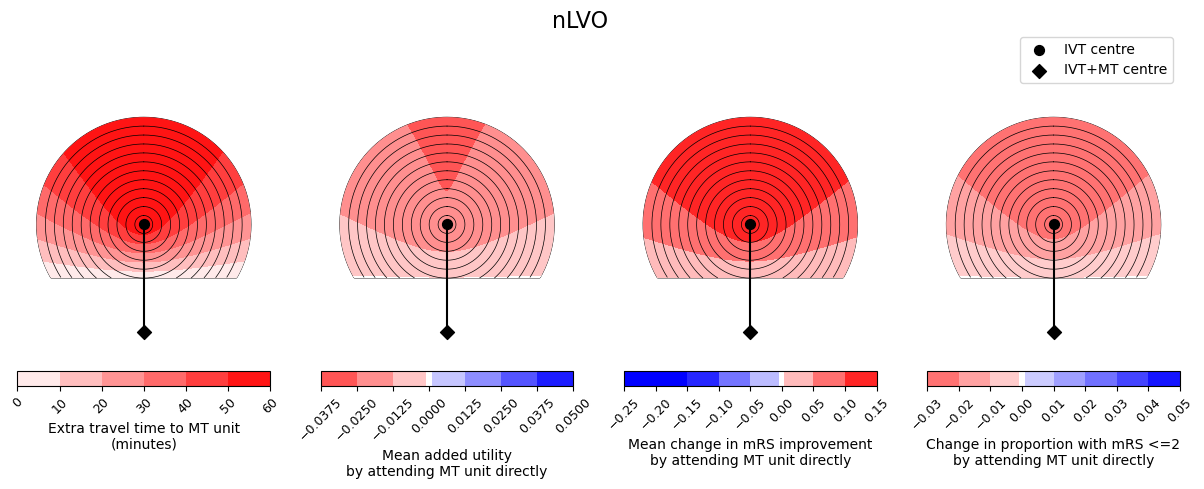

In [229]:
outcome_circle_plots(
    -grid_time_travel_directly_diff,
    df_nlvo_ivt_diff,
    fixed_times['travel_ivt_to_mt'],
    params_time,
    params_util,
    params_mRS,
    params_good,
    coords_valid,
    title='nLVO',
)

added_utility  0.0180  0.0307
mrs_shift -0.1621 -0.0935
mrs_less_equal_2  0.0188  0.0326


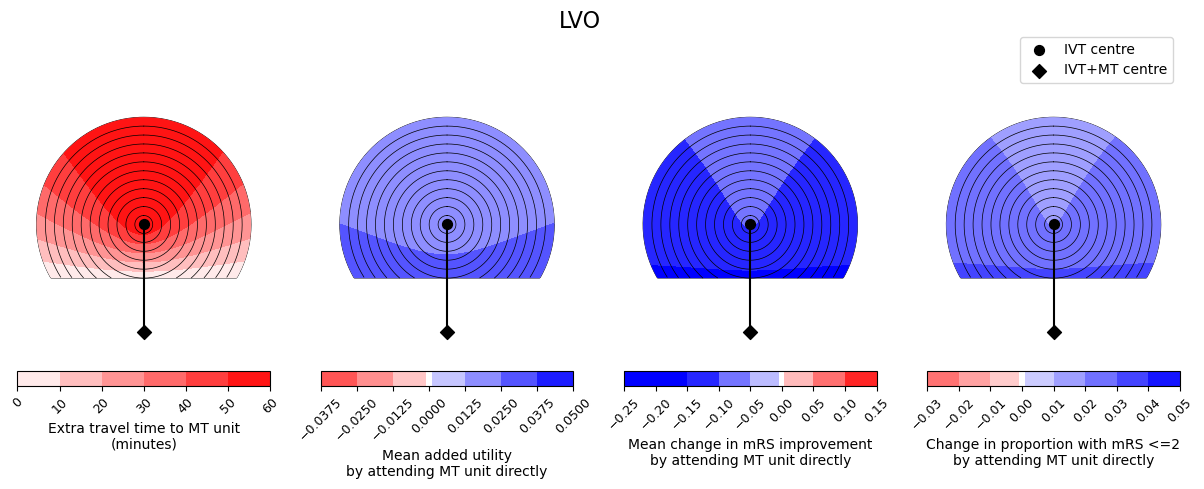

In [230]:
outcome_circle_plots(
    -grid_time_travel_directly_diff,
    df_lvo_diff,
    fixed_times['travel_ivt_to_mt'],
    params_time,
    params_util,
    params_mRS,
    params_good,
    coords_valid,
    title='LVO',
)

added_utility  0.0126  0.0437
mrs_shift -0.2308 -0.0592
mrs_less_equal_2  0.0125  0.0464


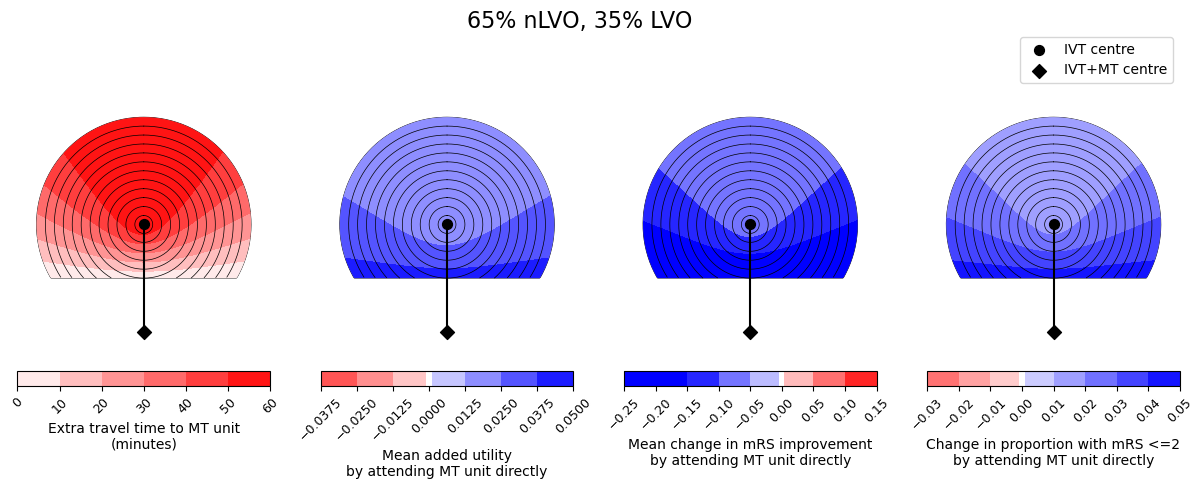

In [231]:
outcome_circle_plots(
    -grid_time_travel_directly_diff,
    df_mixed_diff,
    fixed_times['travel_ivt_to_mt'],
    params_time,
    params_util,
    params_mRS,
    params_good,
    coords_valid,
    title='65% nLVO, 35% LVO',
)

## One big figure with all circle grids

In [232]:
def big_outcome_circle_plots(
        grid_times_diff,
        dfs,
        time_travel_ivt_to_mt,
        params_time,
        params_util,
        params_mRS,
        params_good,
        title='',
        row_titles=[],
        col_titles=[],
    ):
    if len(row_titles) == 0:
        row_titles = [''] * len(dfs)
    if len(col_titles) == 0:
        col_titles = [''] * 4
    

    time_step_circle = 5
    circ_linewidth = 0.5

    # Plot setup:  
    fig, axs = plt.subplots(
        4, 4, figsize=(12, 10), 
        gridspec_kw={'wspace': 0.2, 'hspace': 0.0, 'height_ratios': [20, 20, 20, 1]}
    )
    leg_drawn = False

    for d, df_diff in enumerate(dfs):
        params_time['ax'] = axs[d, 0]
        params_time['ax_cbar'] = axs[-1, 0]
        params_util['ax'] = axs[d, 1]
        params_util['ax_cbar'] = axs[-1, 1]
        params_mRS['ax'] = axs[d, 2]
        params_mRS['ax_cbar'] = axs[-1, 2]
        params_good['ax'] = axs[d, 3]
        params_good['ax_cbar'] = axs[-1, 3]
    
        for i, params in enumerate([params_time, params_util, params_mRS, params_good]):
            if params['col'] != None:
                grid = df_diff[params['col']].values.reshape(grid_times_diff.shape)
            else:
                grid = grid_times_diff

            if params['level_step'] is None:
                params['cbar_ticks'] = None
            else:
                params['cbar_ticks'] = np.arange(
                    params['vmin'], params['vmax'] + params['level_step'], params['level_step'])

            if ((params['col'] is None) & (d < (len(dfs) -1))):
                pass
            else:
                circle_plot(
                    grid,
                    time_travel_ivt_to_mt,
                    time_travel_max,
                    time_step_circle,
                    params['vmin'],
                    params['vmax'],
                    ivt_coords=ivt_coords,
                    mt_coords=mt_coords,
                    extent=extent,
                    imshow=0,
                    ax=params['ax'],
                    cax=params['ax_cbar'],
                    cmap=params['cmap'],
                    cbar_label=params['cbar_label'],
                    cbar_orientation='horizontal',
                    # cbar_format_str='{:3.2f}',
                    levels=params['levels'],
                    cbar_ticks=params['cbar_ticks']
                )
            
                if leg_drawn is False:
                    # Draw legend now:
                    fig.legend(loc='upper right', bbox_to_anchor=[0.9, 0.95], ncol=1, frameon=True)
                    leg_drawn = True
    
            ax = params['ax']
            # ax.set_title(params['title'])
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ['top', 'bottom', 'left', 'right']:
                ax.spines[spine].set_color('None')
            ax.set_ylim(-82,82)
            # Reduce font size of ax.xaxis.label
            ax.tick_params(axis='both', which='major', labelsize=9)
    
            # Rotate colourbar tick labels to prevent overlapping:
            for tick in params['ax_cbar'].get_xticklabels():
                tick.set_rotation(45)
                tick.set_fontsize(9)
                tick.set_horizontalalignment('center')

    for i, row_title in enumerate(row_titles):
        axs[i, 0].set_ylabel(row_title, rotation=0, fontsize=14, labelpad=50.0)#, ha='right')
    for i, col_title in enumerate(col_titles):
        axs[0, i].set_xlabel(col_title, fontsize=14)
        axs[0, i].xaxis.set_label_position('top')

    # Set supertitle 
    fig.suptitle(title, fontsize=16, y=1.05)

    filename = (f'circle_plots_stroke_type_all_60_60')
    plt.savefig('./images/'+filename+'.jpg', dpi=300, bbox_inches='tight')
    plt.show()

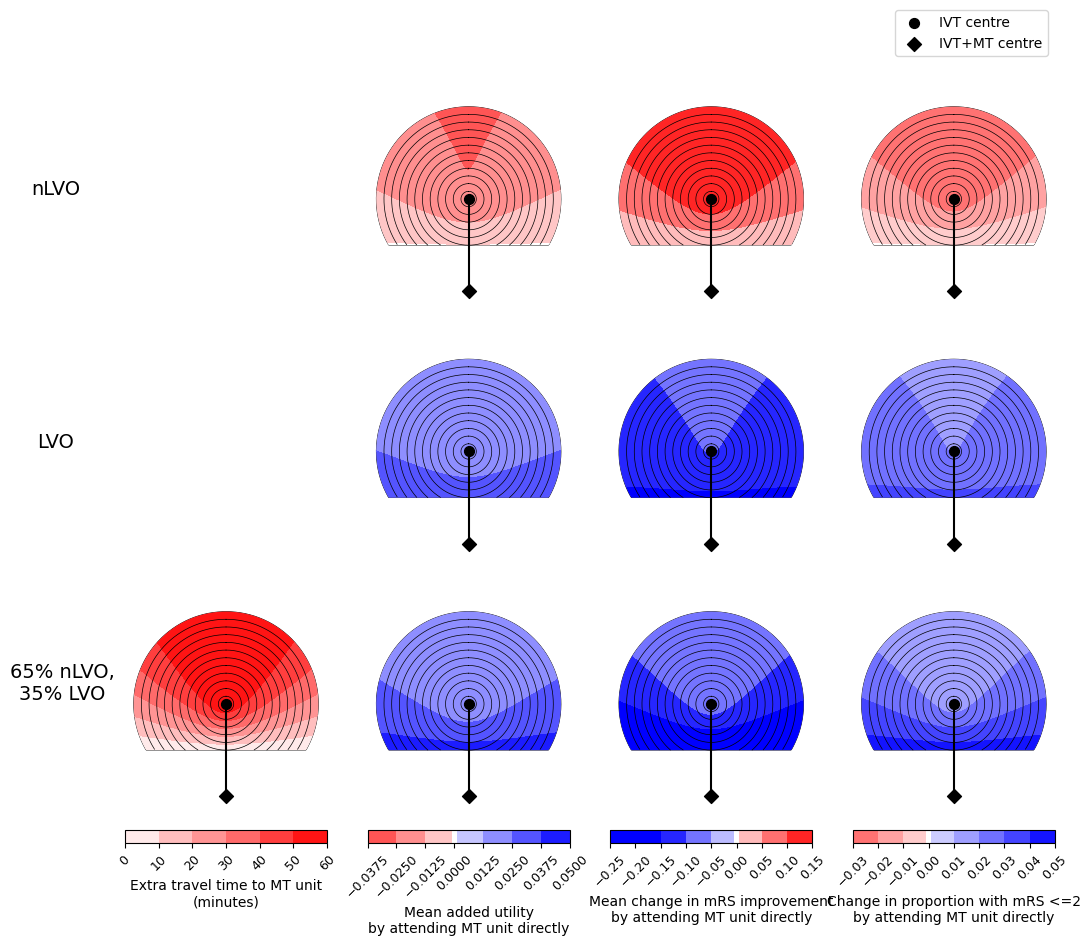

In [233]:
big_outcome_circle_plots(
    -grid_time_travel_directly_diff,
    [df_nlvo_ivt_diff, df_lvo_diff, df_mixed_diff],
    fixed_times['travel_ivt_to_mt'],
    params_time,
    params_util,
    params_mRS,
    params_good,
    row_titles=['nLVO', 'LVO', '65% nLVO,\n35% LVO'],
    col_titles=[],
)